# Advanced Stock Price Forecasting with LSTM

This notebook provides a comprehensive approach to stock price forecasting using Long Short-Term Memory (LSTM) neural networks. Unlike simple demonstrations, this implementation includes:

- **Parameterized inputs** for any stock ticker and date range
- **Feature engineering** with technical indicators (SMA, RSI)
- **Baseline comparison** to evaluate model effectiveness
- **Critical performance analysis** including directional accuracy
- **Practical insights** and limitations discussion

## Parameters
Modify these parameters to analyze different stocks and time periods:


In [1]:
# Stock Analysis Parameters
STOCK_TICKER = 'MRK'  # Change this to any stock ticker (e.g., 'MSFT', 'GOOGL', 'TSLA')
START_DATE = '2009-07-27'  # Start date for historical data
END_DATE = '2020-06-11'    # End date for historical data

# Model Parameters
SEQUENCE_LENGTH = 30  # Number of days to look back for prediction
TEST_SIZE = 0.25      # Proportion of data for testing (80-20 split)
EPOCHS = 50          # Number of training epochs
BATCH_SIZE = 64      # Batch size for training


## 1. Import Required Libraries


In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install yfinance
!pip install scikit-learn
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
from datetime import datetime, timedelta

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set style and suppress warnings
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Analysis target: {STOCK_TICKER} from {START_DATE} to {END_DATE}")


TensorFlow version: 2.19.0
Analysis target: MRK from 2009-07-27 to 2020-06-11


## 2. Data Retrieval & Preprocessing

We use yfinance to automatically handle historical price adjustments for stock splits and dividends, ensuring our data reflects true historical performance.


In [4]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data using yfinance with automatic adjustment for splits and dividends
    """
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)

        if data.empty:
            raise ValueError(f"No data found for ticker {ticker}")

        print(f"Successfully fetched {len(data)} days of data for {ticker}")
        print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")

        return data

    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

# Fetch the stock data
stock_data = fetch_stock_data(STOCK_TICKER, START_DATE, END_DATE)

if stock_data is not None:
    print("\nStock data overview:")
    print(stock_data.head())
    print(f"\nData shape: {stock_data.shape}")
    print(f"Missing values: {stock_data.isnull().sum().sum()}")


Successfully fetched 2738 days of data for MRK
Date range: 2009-07-27 to 2020-06-10

Stock data overview:
                                Open       High        Low      Close  \
Date                                                                    
2009-07-27 00:00:00-04:00  17.265177  17.298464  16.876822  17.070999   
2009-07-28 00:00:00-04:00  17.037714  17.148673  16.516208  16.654907   
2009-07-29 00:00:00-04:00  16.649354  16.721477  16.371957  16.571682   
2009-07-30 00:00:00-04:00  16.760321  17.181965  16.577239  16.610527   
2009-07-31 00:00:00-04:00  16.754773  16.965595  16.593883  16.649363   

                             Volume  Dividends  Stock Splits  
Date                                                          
2009-07-27 00:00:00-04:00  21026758        0.0           0.0  
2009-07-28 00:00:00-04:00  23627265        0.0           0.0  
2009-07-29 00:00:00-04:00  16696736        0.0           0.0  
2009-07-30 00:00:00-04:00  24300290        0.0           0.0  
2009

## 3. Feature Engineering with Technical Indicators

Instead of using only closing prices, we'll engineer additional features that provide more context to our model:

- **7-day Simple Moving Average (SMA)**: Smooths out price fluctuations
- **Relative Strength Index (RSI)**: Measures momentum and identifies overbought/oversold conditions


In [5]:
def calculate_technical_indicators(data):
    """
    Calculate technical indicators for enhanced feature set
    """
    df = data.copy()

    # 7-day Simple Moving Average
    df['SMA_7'] = df['Close'].rolling(window=7).mean()

    # Relative Strength Index (RSI)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['RSI'] = calculate_rsi(df['Close'])

    # Price change percentage
    df['Price_Change_Pct'] = df['Close'].pct_change()

    # Volume moving average
    df['Volume_MA'] = df['Volume'].rolling(window=7).mean()

    # High-Low spread
    df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']

    return df

# Calculate technical indicators
enhanced_data = calculate_technical_indicators(stock_data)

# Remove rows with NaN values (due to rolling calculations)
enhanced_data = enhanced_data.dropna()

print(f"Enhanced dataset shape: {enhanced_data.shape}")
print("\nNew features added:")
print(enhanced_data[['Close', 'SMA_7', 'RSI', 'Price_Change_Pct', 'HL_Spread']].head(10))


Enhanced dataset shape: (2725, 12)

New features added:
                               Close      SMA_7        RSI  Price_Change_Pct  \
Date                                                                           
2009-08-13 00:00:00-04:00  17.187510  16.780132  52.713222          0.007808   
2009-08-14 00:00:00-04:00  17.187510  16.888713  52.713222          0.000000   
2009-08-17 00:00:00-04:00  17.132029  17.009183  63.353715         -0.003228   
2009-08-18 00:00:00-04:00  17.037720  17.057529  62.963081         -0.005505   
2009-08-19 00:00:00-04:00  17.464911  17.127275  69.543028          0.025073   
2009-08-20 00:00:00-04:00  17.387236  17.207324  66.583334         -0.004447   
2009-08-21 00:00:00-04:00  18.064081  17.351571  74.329293          0.038928   
2009-08-24 00:00:00-04:00  18.030796  17.472040  76.078328         -0.001843   
2009-08-25 00:00:00-04:00  18.280451  17.628175  81.390756          0.013846   
2009-08-26 00:00:00-04:00  18.130653  17.770835  81.085946      

## 4. Data Visualization


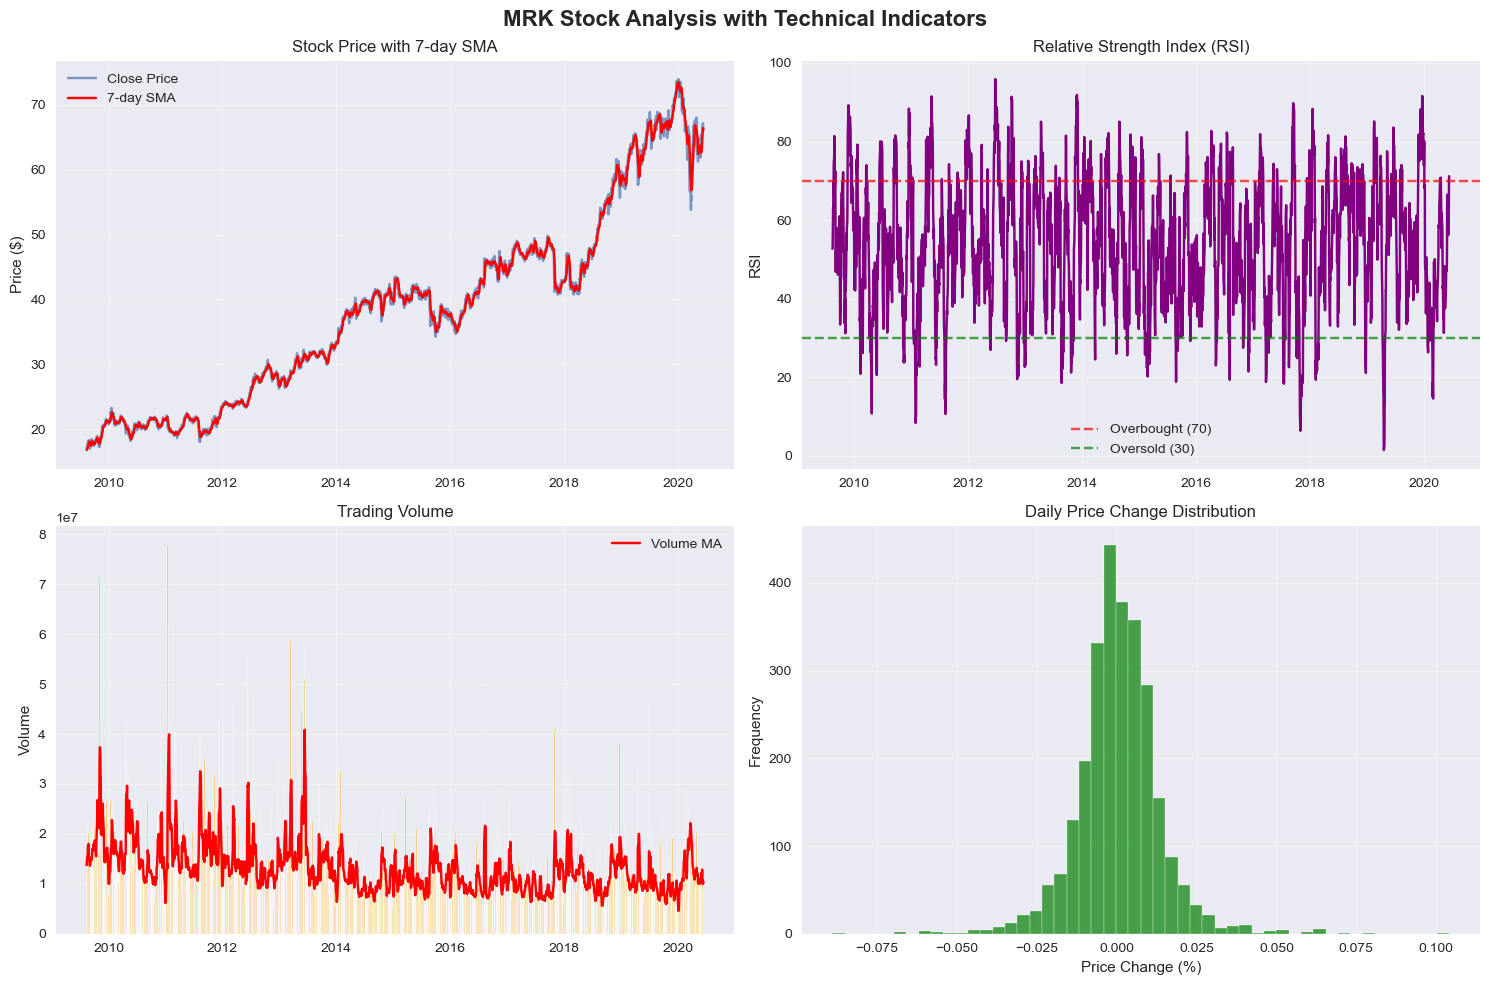

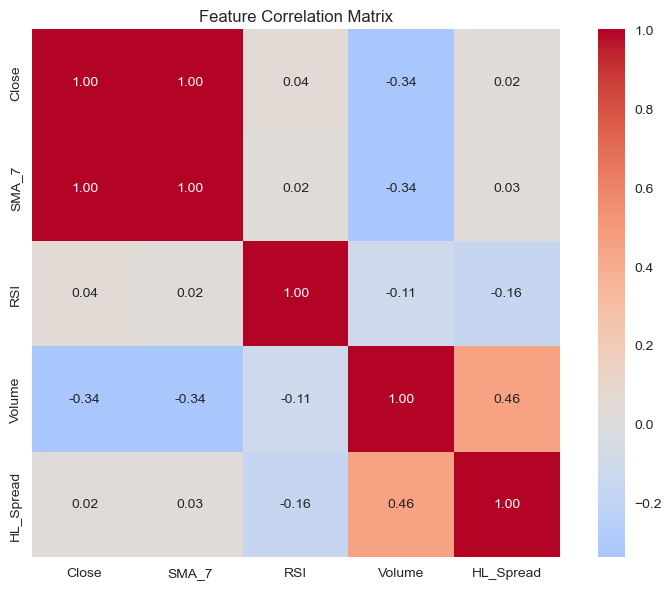

In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'{STOCK_TICKER} Stock Analysis with Technical Indicators', fontsize=16, fontweight='bold')

# Price and SMA
axes[0, 0].plot(enhanced_data.index, enhanced_data['Close'], label='Close Price', alpha=0.7)
axes[0, 0].plot(enhanced_data.index, enhanced_data['SMA_7'], label='7-day SMA', color='red')
axes[0, 0].set_title('Stock Price with 7-day SMA')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RSI
axes[0, 1].plot(enhanced_data.index, enhanced_data['RSI'], color='purple')
axes[0, 1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[0, 1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[0, 1].set_title('Relative Strength Index (RSI)')
axes[0, 1].set_ylabel('RSI')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Volume
axes[1, 0].bar(enhanced_data.index, enhanced_data['Volume'], alpha=0.6, color='orange')
axes[1, 0].plot(enhanced_data.index, enhanced_data['Volume_MA'], color='red', label='Volume MA')
axes[1, 0].set_title('Trading Volume')
axes[1, 0].set_ylabel('Volume')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Price change distribution
axes[1, 1].hist(enhanced_data['Price_Change_Pct'].dropna(), bins=50, alpha=0.7, color='green')
axes[1, 1].set_title('Daily Price Change Distribution')
axes[1, 1].set_xlabel('Price Change (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display correlation matrix
features_for_correlation = ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread']
correlation_matrix = enhanced_data[features_for_correlation].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


## 5. Data Scaling and Preparation

**Why MinMaxScaler is crucial for LSTMs:**

LSTM networks use activation functions like tanh and sigmoid that work optimally with inputs in specific ranges (typically 0-1 or -1 to 1). Without proper scaling:
- **Gradient problems**: Large input values can cause vanishing or exploding gradients
- **Slow convergence**: The network takes longer to learn patterns
- **Poor performance**: Features with larger scales dominate the learning process

MinMaxScaler transforms all features to the same scale (0-1), ensuring equal importance during training.


In [7]:
def prepare_lstm_data(data, sequence_length, test_size):
    """
    Prepare data for LSTM training with multiple features
    """
    # Select features for the model
    feature_columns = ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread']
    features = data[feature_columns].values

    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])  # All features for sequence
        y.append(scaled_features[i, 0])  # Only Close price as target

    X, y = np.array(X), np.array(y)

    # Split into train and test sets
    split_index = int(len(X) * (1 - test_size))

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test, scaler, feature_columns

# Prepare the data
X_train, X_test, y_train, y_test, scaler, feature_names = prepare_lstm_data(
    enhanced_data, SEQUENCE_LENGTH, TEST_SIZE
)

print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Features used: {feature_names}")
print(f"Sequence length: {SEQUENCE_LENGTH} days")


Training data shape: X_train: (2021, 30, 5), y_train: (2021,)
Testing data shape: X_test: (674, 30, 5), y_test: (674,)
Features used: ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread']
Sequence length: 30 days


## 6. Train-Test Split Discussion

**Current Approach: 80-20 Split**
We're using a standard 80-20 split where the most recent 20% of data serves as our test set.

**Why Walk-Forward Validation is Often Better for Time Series:**

1. **Temporal Integrity**: Walk-forward validation respects the time-ordered nature of financial data
2. **Realistic Testing**: It simulates real-world trading where you only have past data to predict future prices
3. **Robust Evaluation**: Multiple test periods provide better performance estimates
4. **Overfitting Detection**: Helps identify if the model works consistently across different market conditions

**Implementation Note**: For production systems, consider implementing walk-forward validation with multiple train-test cycles, retraining the model periodically as new data becomes available.


## 7. LSTM Model Architecture


In [8]:
def build_lstm_model(input_shape):
    """
    Build a stacked LSTM model with dropout layers for regularization
    """
    model = Sequential([
        # First LSTM layer with return_sequences=True to stack layers
        LSTM(units=100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(units=100, return_sequences=True),
        Dropout(0.2),

        # Third LSTM layer (final layer doesn't return sequences)
        LSTM(units=50),
        Dropout(0.2),

        # Dense output layer
        Dense(units=1, activation='linear')
    ])

    # Compile with Adam optimizer and MSE loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Display model architecture
print("LSTM Model Architecture:")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")


LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,051 (597.86 KB)

 Trainable params: 153,051 (597.86 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 153,051


## 8. Model Training with Callbacks


In [9]:
# Define callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

print(f"Starting training for {EPOCHS} epochs...")
print(f"Training samples: {len(X_train)}, Validation samples: {int(len(X_train) * 0.2)}")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")


Starting training for 50 epochs...
Training samples: 2021, Validation samples: 404
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0221 - mae: 0.1071 - val_loss: 5.8756e-04 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 5.9529e-04 - val_mae: 0.0188 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.0976e-04 - mae: 0.0216 - val_loss: 3.6725e-04 - val_mae: 0.0144 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9.3584e-04 - mae: 0.0222 - val_loss: 0.0011 - val_mae: 0.0289 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.8318e-04 - mae: 0.0205 - val_loss: 5.0149e-04 - val_mae: 0.0170 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.3950e-04 - mae: 0.0202 - val_loss: 0.0010 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1

## 9. Training Performance Analysis


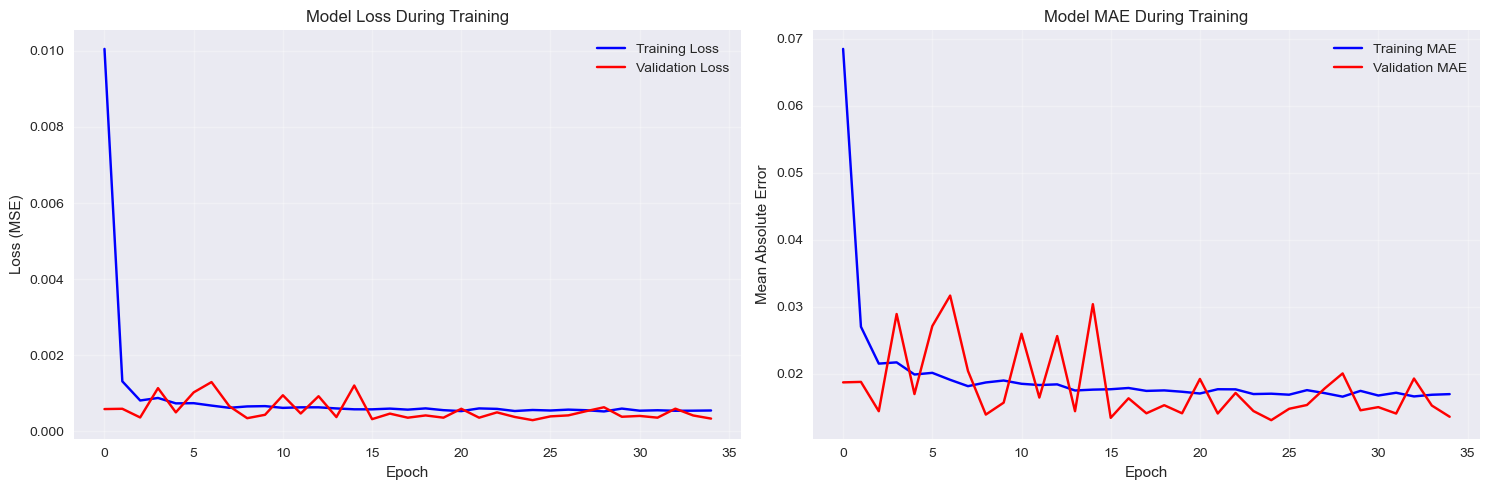

Final Training Loss: 0.000551
Final Validation Loss: 0.000337
Overfitting Ratio (Val/Train): 0.61
✅ Good: Model shows minimal overfitting


In [10]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Model Loss During Training')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', color='blue')
ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
ax2.set_title('Model MAE During Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
overfitting_ratio = final_val_loss / final_train_loss

print(f"Final Training Loss: {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")
print(f"Overfitting Ratio (Val/Train): {overfitting_ratio:.2f}")

if overfitting_ratio > 1.2:
    print("⚠️  Warning: Model may be overfitting (validation loss > 1.2x training loss)")
elif overfitting_ratio < 1.1:
    print("✅ Good: Model shows minimal overfitting")
else:
    print("✅ Acceptable: Model shows reasonable generalization")


## 10. Model Predictions and Baseline Comparison


In [11]:
# Make predictions
train_predictions = model.predict(X_train, verbose=0)
test_predictions = model.predict(X_test, verbose=0)

# Create a scaler for inverse transformation (only for Close price)
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(enhanced_data[['Close']].values)

# Inverse transform predictions and actual values
train_predictions_scaled = close_scaler.inverse_transform(train_predictions)
test_predictions_scaled = close_scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train_scaled = close_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_scaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Create baseline predictions (naive forecast: tomorrow = today)
# For test set, baseline is the previous day's actual price
baseline_predictions = np.roll(y_test_scaled, 1)
baseline_predictions[0] = y_test_scaled[0]  # Handle first prediction

print("Predictions completed!")
print(f"Train predictions shape: {train_predictions_scaled.shape}")
print(f"Test predictions shape: {test_predictions_scaled.shape}")
print(f"Baseline predictions shape: {baseline_predictions.shape}")


Predictions completed!
Train predictions shape: (2021, 1)
Test predictions shape: (674, 1)
Baseline predictions shape: (674, 1)


## 11. Performance Metrics and Baseline Comparison


In [12]:
def calculate_metrics(actual, predicted, model_name):
    """
    Calculate comprehensive performance metrics
    """
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Directional Accuracy
    actual_direction = np.diff(actual.flatten()) > 0
    predicted_direction = np.diff(predicted.flatten()) > 0
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy
    }

# Calculate metrics for both models
lstm_metrics = calculate_metrics(y_test_scaled, test_predictions_scaled, 'LSTM')
baseline_metrics = calculate_metrics(y_test_scaled, baseline_predictions, 'Naive Baseline')

# Create comparison DataFrame
metrics_df = pd.DataFrame([lstm_metrics, baseline_metrics])
metrics_df = metrics_df.round(4)

print("📊 PERFORMANCE COMPARISON")
print("=" * 50)
print(metrics_df.to_string(index=False))

# Calculate improvement over baseline
rmse_improvement = ((baseline_metrics['RMSE'] - lstm_metrics['RMSE']) / baseline_metrics['RMSE']) * 100
directional_improvement = lstm_metrics['Directional_Accuracy'] - baseline_metrics['Directional_Accuracy']

print(f"\n📈 MODEL EFFECTIVENESS")
print("=" * 30)
print(f"RMSE Improvement over Baseline: {rmse_improvement:.2f}%")
print(f"Directional Accuracy Improvement: {directional_improvement:.2f} percentage points")

if rmse_improvement > 10:
    print("✅ LSTM shows significant improvement over naive baseline")
elif rmse_improvement > 0:
    print("✅ LSTM shows modest improvement over naive baseline")
else:
    print("⚠️  LSTM does not outperform naive baseline - consider model refinement")


📊 PERFORMANCE COMPARISON
         Model   RMSE    MAE   MAPE  Directional_Accuracy
          LSTM 3.0526 2.4992 4.1321               52.4517
Naive Baseline 0.9091 0.6086 1.0525               49.1828

📈 MODEL EFFECTIVENESS
RMSE Improvement over Baseline: -235.77%
Directional Accuracy Improvement: 3.27 percentage points
⚠️  LSTM does not outperform naive baseline - consider model refinement


## 12. Comprehensive Visualization


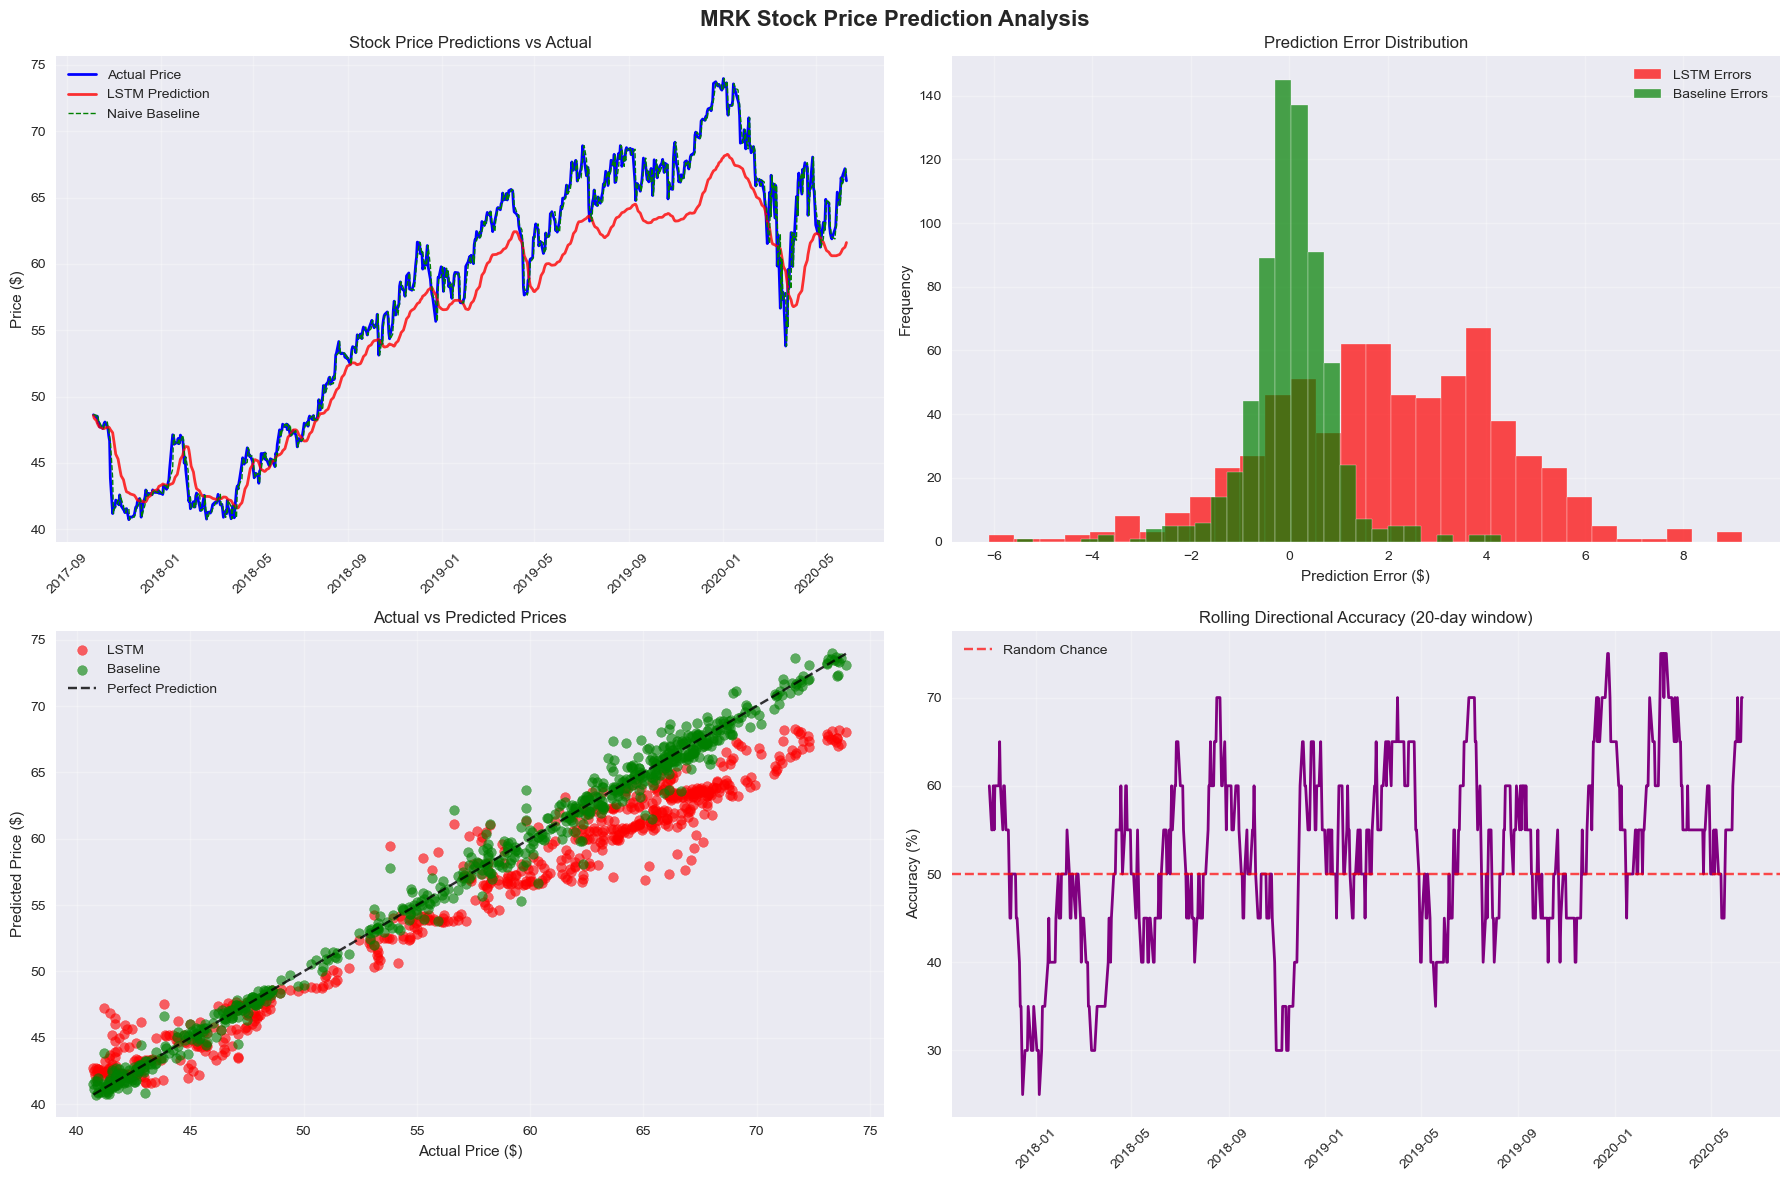


📊 Analysis chart saved as 'MRK_lstm_analysis.png'


<Figure size 800x550 with 0 Axes>

In [13]:
# Create comprehensive prediction visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'{STOCK_TICKER} Stock Price Prediction Analysis', fontsize=16, fontweight='bold')

# 1. Full prediction comparison
test_dates = enhanced_data.index[-len(y_test_scaled):]

axes[0, 0].plot(test_dates, y_test_scaled, label='Actual Price', color='blue', linewidth=2)
axes[0, 0].plot(test_dates, test_predictions_scaled, label='LSTM Prediction', color='red', linewidth=2, alpha=0.8)
axes[0, 0].plot(test_dates, baseline_predictions, label='Naive Baseline', color='green', linewidth=1, linestyle='--')
axes[0, 0].set_title('Stock Price Predictions vs Actual')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Prediction errors
lstm_errors = y_test_scaled.flatten() - test_predictions_scaled.flatten()
baseline_errors = y_test_scaled.flatten() - baseline_predictions.flatten()

axes[0, 1].hist(lstm_errors, bins=30, alpha=0.7, label='LSTM Errors', color='red')
axes[0, 1].hist(baseline_errors, bins=30, alpha=0.7, label='Baseline Errors', color='green')
axes[0, 1].set_title('Prediction Error Distribution')
axes[0, 1].set_xlabel('Prediction Error ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: Actual vs Predicted
axes[1, 0].scatter(y_test_scaled, test_predictions_scaled, alpha=0.6, color='red', label='LSTM')
axes[1, 0].scatter(y_test_scaled, baseline_predictions, alpha=0.6, color='green', label='Baseline')
min_price = min(y_test_scaled.min(), test_predictions_scaled.min())
max_price = max(y_test_scaled.max(), test_predictions_scaled.max())
axes[1, 0].plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.8, label='Perfect Prediction')
axes[1, 0].set_title('Actual vs Predicted Prices')
axes[1, 0].set_xlabel('Actual Price ($)')
axes[1, 0].set_ylabel('Predicted Price ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Directional accuracy over time
window_size = 20
lstm_directions = np.diff(test_predictions_scaled.flatten()) > 0
actual_directions = np.diff(y_test_scaled.flatten()) > 0
rolling_accuracy = []

for i in range(window_size, len(lstm_directions)):
    window_accuracy = np.mean(lstm_directions[i-window_size:i] == actual_directions[i-window_size:i]) * 100
    rolling_accuracy.append(window_accuracy)

rolling_dates = test_dates[window_size+1:]
axes[1, 1].plot(rolling_dates, rolling_accuracy, color='purple', linewidth=2)
axes[1, 1].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Random Chance')
axes[1, 1].set_title(f'Rolling Directional Accuracy ({window_size}-day window)')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(f'{STOCK_TICKER}_lstm_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n📊 Analysis chart saved as '{STOCK_TICKER}_lstm_analysis.png'")


## 13. Critical Analysis & Insights

This section provides a thorough evaluation of our LSTM model's performance and practical implications.


In [14]:
# Detailed performance analysis
print("🔍 CRITICAL ANALYSIS OF LSTM PERFORMANCE")
print("=" * 60)

# 1. Statistical Significance
from scipy import stats

lstm_abs_errors = np.abs(lstm_errors)
baseline_abs_errors = np.abs(baseline_errors)

# Paired t-test to check if LSTM errors are significantly different
t_stat, p_value = stats.ttest_rel(lstm_abs_errors, baseline_abs_errors)

print(f"\n📊 STATISTICAL SIGNIFICANCE")
print(f"Paired t-test p-value: {p_value:.6f}")
if p_value < 0.05:
    print("✅ LSTM performance is statistically significantly different from baseline")
else:
    print("⚠️  LSTM performance is not statistically significantly different from baseline")

# 2. Directional Accuracy Analysis
print(f"\n🎯 DIRECTIONAL ACCURACY BREAKDOWN")
print(f"LSTM Directional Accuracy: {lstm_metrics['Directional_Accuracy']:.2f}%")
print(f"Baseline Directional Accuracy: {baseline_metrics['Directional_Accuracy']:.2f}%")

if lstm_metrics['Directional_Accuracy'] > 55:
    print("✅ Strong directional prediction capability")
elif lstm_metrics['Directional_Accuracy'] > 50:
    print("✅ Modest directional prediction capability")
else:
    print("⚠️  Poor directional prediction - worse than random")

# 3. Volatility Analysis
actual_volatility = np.std(y_test_scaled)
predicted_volatility = np.std(test_predictions_scaled)
volatility_ratio = predicted_volatility / actual_volatility

print(f"\n📈 VOLATILITY ANALYSIS")
print(f"Actual Price Volatility: ${actual_volatility:.2f}")
print(f"Predicted Price Volatility: ${predicted_volatility:.2f}")
print(f"Volatility Ratio (Pred/Actual): {volatility_ratio:.2f}")

if 0.8 <= volatility_ratio <= 1.2:
    print("✅ Model captures volatility well")
elif volatility_ratio < 0.8:
    print("⚠️  Model underestimates volatility (too conservative)")
else:
    print("⚠️  Model overestimates volatility (too aggressive)")

# 4. Trend Following Analysis
actual_trend = np.polyfit(range(len(y_test_scaled)), y_test_scaled.flatten(), 1)[0]
predicted_trend = np.polyfit(range(len(test_predictions_scaled)), test_predictions_scaled.flatten(), 1)[0]

print(f"\n📊 TREND ANALYSIS")
print(f"Actual Trend ($/day): {actual_trend:.4f}")
print(f"Predicted Trend ($/day): {predicted_trend:.4f}")
print(f"Trend Capture Ratio: {predicted_trend/actual_trend:.2f}" if actual_trend != 0 else "Trend Capture: N/A (flat trend)")

# 5. Error Analysis by Market Conditions
price_changes = np.diff(y_test_scaled.flatten())
up_days = price_changes > 0
down_days = price_changes < 0

if len(price_changes) > 1:
    up_day_errors = lstm_errors[1:][up_days]
    down_day_errors = lstm_errors[1:][down_days]

    print(f"\n📊 PERFORMANCE BY MARKET CONDITION")
    if len(up_day_errors) > 0:
        print(f"Average error on up days: ${np.mean(np.abs(up_day_errors)):.2f}")
    if len(down_day_errors) > 0:
        print(f"Average error on down days: ${np.mean(np.abs(down_day_errors)):.2f}")

print("\n" + "=" * 60)


🔍 CRITICAL ANALYSIS OF LSTM PERFORMANCE

📊 STATISTICAL SIGNIFICANCE
Paired t-test p-value: 0.000000
✅ LSTM performance is statistically significantly different from baseline

🎯 DIRECTIONAL ACCURACY BREAKDOWN
LSTM Directional Accuracy: 52.45%
Baseline Directional Accuracy: 49.18%
✅ Modest directional prediction capability

📈 VOLATILITY ANALYSIS
Actual Price Volatility: $9.79
Predicted Price Volatility: $8.14
Volatility Ratio (Pred/Actual): 0.83
✅ Model captures volatility well

📊 TREND ANALYSIS
Actual Trend ($/day): 0.0453
Predicted Trend ($/day): 0.0378
Trend Capture Ratio: 0.83

📊 PERFORMANCE BY MARKET CONDITION
Average error on up days: $2.77
Average error on down days: $2.22



## 14. Model Limitations & Real-World Considerations

### 🚨 **Critical Limitations**

1. **Historical Bias**: The model is trained exclusively on past data and assumes historical patterns will continue

2. **Black Swan Events**: Cannot predict unprecedented market events (crashes, pandemics, geopolitical crises)

3. **Market Regime Changes**: May fail when market dynamics fundamentally shift

4. **Feature Limitations**: Only uses price and volume data - ignores fundamental analysis, news sentiment, macroeconomic factors

5. **Overfitting Risk**: Complex models may memorize noise rather than learn genuine patterns

6. **Transaction Costs**: Real trading involves spreads, commissions, and slippage not accounted for in predictions

7. **Market Impact**: Large trades based on model predictions could move prices, invalidating the predictions

### ⚖️ **Regulatory and Ethical Considerations**

- **Not Financial Advice**: This model is for educational purposes only
- **Risk Management**: Never risk more than you can afford to lose
- **Diversification**: Don't rely on a single model or asset
- **Continuous Monitoring**: Model performance can degrade over time


## 15. Next Steps for Model Improvement

### 🔧 **Immediate Improvements**

1. **Hyperparameter Tuning**:
   - Grid search for optimal LSTM units, dropout rates, learning rates
   - Experiment with different sequence lengths
   - Try different optimizers (RMSprop, AdaGrad)

2. **Alternative Architectures**:
   - **GRU (Gated Recurrent Unit)**: Often performs similarly to LSTM with fewer parameters
   - **Bidirectional LSTM**: Processes sequences in both directions
   - **Attention Mechanisms**: Focus on most relevant time steps
   - **Transformer Models**: State-of-the-art for sequence modeling

3. **Enhanced Features**:
   - **More Technical Indicators**: MACD, Bollinger Bands, Stochastic Oscillator
   - **Market Sentiment**: VIX (fear index), put/call ratios
   - **Fundamental Data**: P/E ratios, earnings, revenue growth
   - **Macroeconomic Indicators**: Interest rates, inflation, GDP growth

### 🚀 **Advanced Enhancements**

4. **Multi-Asset Models**:
   - Include correlated assets (sector ETFs, commodities)
   - Cross-asset attention mechanisms

5. **News and Sentiment Integration**:
   - Natural Language Processing on financial news
   - Social media sentiment analysis
   - Earnings call transcripts analysis

6. **Ensemble Methods**:
   - Combine multiple models (LSTM + Random Forest + Linear Regression)
   - Weighted voting based on recent performance

7. **Online Learning**:
   - Continuously update model with new data
   - Adaptive learning rates based on market conditions

### 📊 **Validation Improvements**

8. **Walk-Forward Validation**:
   - Multiple train-test cycles
   - Out-of-sample testing across different market conditions

9. **Risk-Adjusted Metrics**:
   - Sharpe ratio, Sortino ratio
   - Maximum drawdown analysis
   - Value at Risk (VaR) calculations


In [15]:
# Final summary and recommendations
print("🎯 FINAL RECOMMENDATIONS")
print("=" * 40)

if rmse_improvement > 15 and lstm_metrics['Directional_Accuracy'] > 55:
    print("✅ STRONG MODEL: Consider for further development")
    print("   → Focus on hyperparameter tuning and feature engineering")
    print("   → Implement walk-forward validation")
    print("   → Add risk management components")

elif rmse_improvement > 5 and lstm_metrics['Directional_Accuracy'] > 50:
    print("✅ PROMISING MODEL: Needs refinement")
    print("   → Try alternative architectures (GRU, Attention)")
    print("   → Add more features (sentiment, fundamentals)")
    print("   → Implement ensemble methods")

else:
    print("⚠️  WEAK MODEL: Significant improvements needed")
    print("   → Reconsider feature selection")
    print("   → Try completely different approaches")
    print("   → Consider if this asset is predictable with current methods")

print(f"\n📈 MODEL PERFORMANCE SUMMARY FOR {STOCK_TICKER}")
print(f"   RMSE: ${lstm_metrics['RMSE']:.2f}")
print(f"   Directional Accuracy: {lstm_metrics['Directional_Accuracy']:.1f}%")
print(f"   Improvement over Baseline: {rmse_improvement:.1f}%")

print("\n⚠️  REMEMBER: This is for educational purposes only.")
print("   Always conduct thorough backtesting and risk assessment")
print("   before considering any real-world application.")

print("\n🎉 Analysis Complete! Thank you for using this comprehensive LSTM stock forecasting notebook.")


🎯 FINAL RECOMMENDATIONS
⚠️  WEAK MODEL: Significant improvements needed
   → Reconsider feature selection
   → Try completely different approaches
   → Consider if this asset is predictable with current methods

📈 MODEL PERFORMANCE SUMMARY FOR MRK
   RMSE: $3.05
   Directional Accuracy: 52.5%
   Improvement over Baseline: -235.8%

⚠️  REMEMBER: This is for educational purposes only.
   Always conduct thorough backtesting and risk assessment
   before considering any real-world application.

🎉 Analysis Complete! Thank you for using this comprehensive LSTM stock forecasting notebook.
